# Conditional VAEs
*"We show that deep generative models and approximate Bayesian inference exploiting recent advances in variational methods can be used to provide significant improvements, making generative approaches highly competitive for semi-supervised learning."*
[Semi-Supervised Learning with Deep Generative Models](https://arxiv.org/abs/1406.5298). Kingma et al 2014.

This work is absolutely not an effort to reproduce results of the cited paper, nor I confine my Implementations to suggestion of the original authors. I have tried to Implement my own limited understanding of the original paper in hope to get better insight about their work. Use this code with no warranty and please respect the accompanying license.

In [1]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')
sys.path.append('../common')

from tools_general import tf, np
from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
from tools_config import data_dir
from tools_train import get_train_params
import matplotlib.pyplot as plt
import imageio

In [2]:
# define parameters
networktype = 'cVAE_MNIST'

work_dir = '../trained_models/%s/' %networktype
if not os.path.exists(work_dir): os.makedirs(work_dir)

## Network definitions

In [3]:
# define networks
from tools_networks import deconv, conv, dense, clipped_crossentropy, dropout

def concat_labels(X, labels):
    if X.get_shape().ndims == 4:
        X_shape = tf.shape(X)
        labels_reshaped = tf.reshape(labels, [-1, 1, 1, 10])
        a = tf.ones([X_shape[0], X_shape[1], X_shape[2], 10])
        X = tf.concat([X, labels_reshaped * a], axis=3)
    return X

def create_VAE_E(Xin, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='vaeE'):
    '''Xin: batchsize * H * W * Cin
       labels: batchsize * num_classes
       output1-2: batchsize * Cout'''
    
    with tf.variable_scope(networktype, reuse=reuse):
        
        Xin = concat_labels(Xin, labels)
        
        Eout = conv(Xin, is_training, kernel_w=4, stride=2, Cout=64, pad=1, trainable=trainable, act='reLu', norm='batchnorm', name='deconv1')  # 14*14
        Eout = conv(Eout, is_training, kernel_w=4, stride=2, Cout=128, pad=1, trainable=trainable, act='reLu', norm='batchnorm', name='deconv2')  # 7*7
        
        posteriorMu = dense(Eout, is_training, trainable=trainable, Cout=Cout, act=None, norm=None, name='dense_mean')
        posteriorSigma = dense(Eout, is_training, trainable=trainable, Cout=Cout, act=None, norm=None, name='dense_var')
    return posteriorMu, posteriorSigma
     
def create_VAE_D(z, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='vaeD'):
    '''z : batchsize * latend_dim 
       labels: batchsize * num_classes
        output: batchsize * 28 * 28 * 1'''
    with tf.variable_scope(networktype, reuse=reuse):
        z = tf.concat(axis=-1, values=[z, labels])
        Gz = dense(z, is_training, Cout=4 * 4 * 256, act='reLu', norm='batchnorm', name='dense1')
        Gz = tf.reshape(Gz, shape=[-1, 4, 4, 256])  # 4
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=256, trainable=trainable, act='reLu', norm='batchnorm', name='deconv1')  # 11
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=128, trainable=trainable, act='reLu', norm='batchnorm', name='deconv2')  # 25
        Gz = deconv(Gz, is_training, kernel_w=4, stride=Cout, Cout=1, act=None, norm=None, name='deconv3')  # 28
        Gz = tf.nn.sigmoid(Gz)
    return Gz

def create_vae_trainer(base_lr=1e-4, networktype='VAE', latendDim=100):
    '''Train a Variational AutoEncoder'''
    eps = 1e-5
    
    is_training = tf.placeholder(tf.bool, [], 'is_training')

    inZ = tf.placeholder(tf.float32, [None, latendDim])
    inL = tf.placeholder(tf.float32, [None, 10])
    inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

    posteriorMu, posteriorSigma = create_VAE_E(inX, inL, is_training, Cout=latendDim, trainable=True, reuse=False, networktype=networktype + '_vaeE') 
    
    Z = posteriorSigma * inZ + posteriorMu
    Xrec = create_VAE_D(Z, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_vaeD')
    Xrec_test = create_VAE_D(inZ, inL, is_training, trainable=True, reuse=True, networktype=networktype + '_vaeD')
    
    # E[log P(X|z)]
    reconstruction_loss = tf.reduce_sum((inX -1.0) * tf.log(1.0 - Xrec + eps) - inX * tf.log(Xrec + eps), reduction_indices = [1,2,3])
    # D_KL(Q(z|X) || P(z|X))
    KL_QZ = 0.5 * tf.reduce_sum( tf.exp(posteriorSigma) + tf.square(posteriorMu) - 1 - posteriorSigma, reduction_indices = 1) 
    
    total_loss = tf.reduce_mean( reconstruction_loss + KL_QZ)  
    
    vaetrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.9).minimize(total_loss)

    return vaetrain, total_loss, is_training, inZ, inX, inL, Xrec, Xrec_test, posteriorMu

# Training VAE
You can either get the trained models from [my google drive](https://goo.gl/7PrKD2) or train your own models using the VAE.py script

## Evolution of approximate posterior and likelihood during training with 2D latent space

Here we will keep the latent dimension to only 2 due to visualization matters but basicaly there is an optimum dimensionality in in the latent space which is bigger than 2.

In [13]:
batch_size = 128
base_lr = 1e-5
epochs = 50
latendDim = 2
spl = 200 #sample_per_label

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir + '/' + networktype, batch_size, epochs=epochs,one_hot=False, test_in_each_epoch=1, networktype=networktype)
all_test_set, all_labels = data.test.next_batch(data.test.num_examples)

Xtest = np.zeros([spl*10, 28,28,1])
Xlabel = np.zeros([spl*10, 1])
for num in range(10):
    Xtest[spl*num:spl*num+spl,:] = all_test_set[np.where(all_labels==num)[0]][0:spl]
    Xlabel[spl*num:spl*num+spl,:] = num
Xlabel_onehot = OneHot(Xlabel.astype(np.int32))
Z_test = np.random.normal(size=[spl*10, latendDim], loc=0.0, scale=1.).astype(np.float32)

num_colors = ['C0.','C1.','C2.','C3.','C4.','C5.','C6.','C7.','C8.','C9.']

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir + '/' + networktype, batch_size, epochs=epochs, test_in_each_epoch=1, networktype=networktype)

Extracting ../data//cVAE_MNIST\train-images-idx3-ubyte.gz
Extracting ../data//cVAE_MNIST\train-labels-idx1-ubyte.gz
Extracting ../data//cVAE_MNIST\t10k-images-idx3-ubyte.gz
Extracting ../data//cVAE_MNIST\t10k-labels-idx1-ubyte.gz
Trainset size: 55000 Testset_size: 10000
Extracting ../data//cVAE_MNIST\train-images-idx3-ubyte.gz
Extracting ../data//cVAE_MNIST\train-labels-idx1-ubyte.gz
Extracting ../data//cVAE_MNIST\t10k-images-idx3-ubyte.gz
Extracting ../data//cVAE_MNIST\t10k-labels-idx1-ubyte.gz
Trainset size: 55000 Testset_size: 10000


In [14]:
tf.reset_default_graph() 
with tf.Session() as sess:
    vaetrain, total_loss, is_training, inZ, inX, inL, Xrec,Xrec_test, Qmu = create_vae_trainer(base_lr, networktype=networktype, latendDim=latendDim)
    tf.global_variables_initializer().run()
    
    var_list = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if (networktype.lower() in var.name.lower()) and ('adam' not in var.name.lower())]  
    saver = tf.train.Saver(var_list=var_list, max_to_keep=100)

    test_int = 10
    best_test_loss = np.inf 

    images = []

    for it in range(max_iter): 
        Z = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)

        if it == 2 or it % test_int == 0:
            accumulated_loss = 0.0 
            for i_test in range(test_iter):
                X, labels = data.test.next_batch(batch_size)
                recloss = sess.run(total_loss, feed_dict={inX:X, inL:labels, inZ: Z, is_training:False})
                accumulated_loss = np.add(accumulated_loss, recloss)

            cur_test_loss = np.divide(accumulated_loss, test_iter)
            if cur_test_loss < best_test_loss:
                best_test_loss = cur_test_loss
                if it % (30*test_int) == 0:saver.save(sess, work_dir + "%.3d_model.ckpt" % it)
                [Qmu_cur,Xrec_cur] = sess.run([Qmu,Xrec], feed_dict={inX: Xtest, inL:Xlabel_onehot, inZ: Z_test, is_training:False})
                fname = work_dir+ 'Iter_%d.jpg'%it
                fig = plt.figure(figsize=(10,5))
                fig.suptitle('Iter. #%d, Test_loss = %1.5f'%(it,best_test_loss))
                likelihood = np.zeros([100, 28, 28, 1])
                for num in range(10):
                    ax1 = fig.add_subplot(121)
                    ax1.plot(Qmu_cur[np.where(Xlabel==num)[0],0],Qmu_cur[np.where(Xlabel==num)[0],1],num_colors[num], label='%d'%num)
                    likelihood[np.arange(0,100,10)+num] = Xrec_cur[np.where(Xlabel==num)[0][:10]]
                ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), ncol=1, fancybox=True, shadow=True)
                ax1.set_xlabel('Latent Dimension #1');ax1.set_ylabel('Latent Dimension #2')
                ax1.set_ylim([-7,7]);ax1.set_xlim([-7,7])

                ax2 = fig.add_subplot(122)
                ax2.imshow(vis_square(likelihood, [10, 10]), cmap='gray')
                ax2.set_xticks([])
                ax2.set_yticks([])

                plt.savefig(fname)
                plt.close()
                images.append(imageio.imread(fname))


        if it % (disp_int*100) == 0:print('-- It. %0.4d Best Results yet.[loss = %2.5f] saving results...' % (it,best_test_loss))

        X, labels = data.train.next_batch(batch_size)
        recloss, _ = sess.run([total_loss, vaetrain], feed_dict={inX:X, inL:labels, inZ: Z, is_training:True})

    imageio.mimsave(work_dir+'posterior_likelihood_evolution.gif', images)

-- It. 0000 Best Results yet.[loss = inf] saving results...
-- It. 21400 Best Results yet.[loss = 126.38848] saving results...


In [15]:
display(Image(url=work_dir+'posterior_likelihood_evolution.gif'))

Visulization of a Convolutional Variational Auto-Encoder with 2D latent space Z during training on MNIST dataset (handwritten digits). The Image to the right is the mean of the approximate posterior Q(z|X) and each color represents a class of digits within the dataset. Image to the left shows samples from the likelihood P(X|z) as a way to visualize the predictive prior. The title above shows the iteration number and total loss of the model at the point that images below were produced from the model under training. What we observe is the by the time the generated outputs (left image) get better, the points in the posterior also get into better seperated clusters.

# Experiments
Create demo networks and restore weights

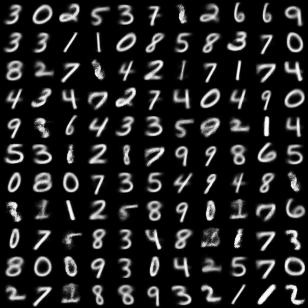

In [17]:
best_iter = 23166 # least cost
best_img = work_dir + 'Iter_%d.jpg' %best_iter
best_model = work_dir + "%.3d_model.ckpt" % best_iter
Image(filename=best_img)

In [18]:
latendDim = 2 # of the best model trained
batch_size = 128

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inZ = tf.placeholder(tf.float32, [None, latendDim])
inL = tf.placeholder(tf.float32, [None, 10])

Xrec = create_VAE_D(inZ, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_vaeD')

tf.global_variables_initializer().run()

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_vaeD')
saver = tf.train.Saver(var_list=var_list)
saver.restore(demo_sess, best_model)

INFO:tensorflow:Restoring parameters from ../trained_models/cVAE_MNIST/23166_model.ckpt


### Generate new data
Approximate samples from the posterior distribution over the latent variables p(z|x)

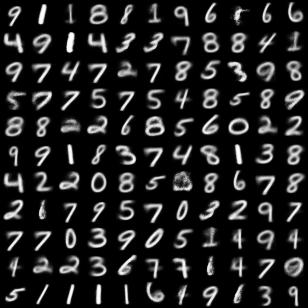

In [19]:
Z_test = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)
labels_test = OneHot(np.random.randint(10, size=[batch_size]), n=10)    

vaeD_sample = demo_sess.run(Xrec, feed_dict={inL:labels_test, inZ: Z_test , is_training:False})
vis_square(vaeD_sample[:121], [11, 11], save_path=work_dir + 'sample.jpg')
Image(filename=work_dir + 'sample.jpg')

### 3) Class Sweep
With the same z slowly move the class labels to smoothly generate different numbers

In [21]:
class_sweep_dir = work_dir+'class_sweep/'
if not os.path.exists(class_sweep_dir): os.makedirs(class_sweep_dir)

batch_size = 100

Z_test = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)
labels_test = OneHot(np.repeat([[0,0,0,0,0,0,0,0,0,0]],batch_size//10,axis=0))

images = []
for num in range(9):
    for p in np.linspace(1.,0.,30):
        count=len(images)
        fname = class_sweep_dir+ 'sweep_temp.jpg'

        for i in range(batch_size): 
            labels_test[i,num] = p; labels_test[i,num+1] = 1-p

        Gz_sample = demo_sess.run(Xrec, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
        img = vis_square(Gz_sample, [10, 10],save_path= fname)
        images.append(imageio.imread(fname))
        try: os.remove(fname)
        except: pass
        
imageio.mimsave(class_sweep_dir+'class_sweep.gif', images)
display(Image(url=class_sweep_dir+'class_sweep.gif'))

### 3) Z-space Sweep
Vary a coefficient alpha that determines how much of two different Z values are used to sample from the generator.
This is also called interpolation in z space in the original paper.

In [23]:
zspace_sweep_dir = work_dir+'zspace_sweep/'
if not os.path.exists(zspace_sweep_dir): os.makedirs(zspace_sweep_dir)
batch_size = 100

Z1 = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)
Z2 = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)

images = []
for alpha in np.linspace(1.,0.,50):
    count=len(images)
    fname = zspace_sweep_dir+'%.2d.jpg'%(count)
    
    Z_test = alpha * Z1 + (1-alpha)*Z2
    labels_test = OneHot(np.repeat([[0,1,2,3,4,5,6,7,8,9]],batch_size//10,axis=0))
    
    Gz_sample = demo_sess.run(Xrec, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
    img = vis_square(Gz_sample, [batch_size//10, 10],save_path=fname)
    images.append(imageio.imread(fname))
    try: os.remove(fname)
    except: pass
    
imageio.mimsave(zspace_sweep_dir+'zspace_sweep.gif', images)
display(Image(url=zspace_sweep_dir+'zspace_sweep.gif'))